## Import 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import skimage.io 
import slgbuilder
from PIL import Image

# This is to fix deprecated alias in numpy, but still used in slgbuilder
np.bool = bool
np.int = int

import sys
sys.path.insert(1, '..')
from functions import *

PATH = 'data/'

The segmentation line is: [3 3 2 2 1 2 2]
The value path is given as: [6 7 5 6 4 5 4]
The sum of the value path is given as: 37


Text(0.5, 1.0, 'Optimal path for delta 1 with value 37')

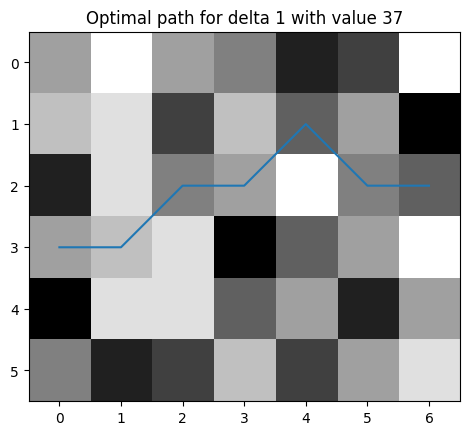

In [2]:
I = np.array([[6, 9, 6, 5, 2, 3, 9],
              [7, 8, 3, 7, 4, 6, 1],
              [2, 8, 5, 6, 9, 5, 4],
              [6, 7, 8, 1, 4, 6, 9],
              [1, 8, 8, 4, 6, 2, 6],
              [5, 2, 3, 7, 3, 6, 8]])
# To change the surface cost, modify the array passed to slgbuilder.GraphObject.
# For example, to use a different cost matrix (e.g., penalize high values more):
delta = 1
surface_cost = np.abs(I-5)  # Example: invert the cost so lower values become higher cost
layer = slgbuilder.GraphObject(surface_cost)

helper = slgbuilder.MaxflowBuilder()
helper.add_object(layer)
helper.add_layered_boundary_cost()
helper.add_layered_smoothness(delta=delta, wrap=False)

helper.solve()
segmentation = helper.what_segments(layer)
segmentation_line = segmentation.shape[0] - np.argmax(segmentation[::-1,:], axis=0) - 1

value_path = I[segmentation_line, np.arange(I.shape[1])]
value = np.sum(value_path)

print(f'The segmentation line is: {segmentation_line}')
print(f'The value path is given as: {value_path}')
print(f'The sum of the value path is given as: {value}')

plt.imshow(I, cmap='gray')
plt.plot(np.arange(len(segmentation_line)), segmentation_line)
plt.title(f'Optimal path for delta {delta} with value {value}')


## 7.4 Exercise: Layered surfaces in 2D

In this exercise you will get familiar with layered surfaces. We will only consider layered surfaces in 2D.


**1. Run the script ```on_surface_cost_example``` which demonstrates the use of on-surface cost**
- In this case we want to detect dark lines, so for on-surface cost we use image intensities. Get familiar with the functions for computing the optimal solution.

**2. Run the script ```in_region_cost_example``` which demonstrates the use of in-region cost**
- In this case we want to separate the dark and the bright regions, so for in-regions cost of dark region we use image intensities $I$, while for bright region we use $255 − I$. Get familiar with the functions for computing the optimal solution and passing the region costs to the solver.

**3. Inspect the image ```rammed-earth-layers-limestone.jpg```**
- Use the layered surface detection to detect the darkest line in the image, shown red in Figure 7.3. Then, detect two dark lines (blue and red line in the figure). Finally, detect the lines partitioning the dark regions, as shown in green in Figure 7.3.


**IMPORTANT:** In order to run the code, use the requirements_week7.txt file to install the necessary packages. and use python 3.9

**1. Run the script ```on_surface_cost_example``` which demonstrates the use of on-surface cost**

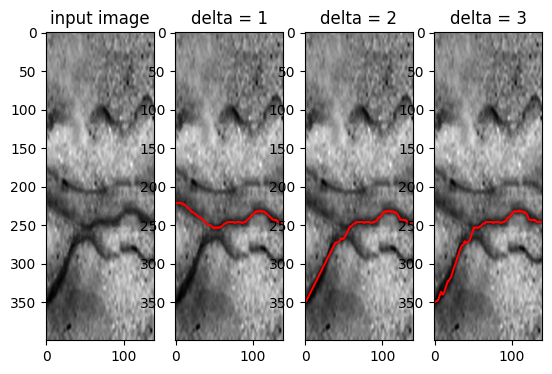

In [3]:
#%% input
I = skimage.io.imread('data/layers_A.png').astype(np.int32)

fig, ax = plt.subplots(1,4)
ax[0].imshow(I, cmap='gray')
ax[0].set_title('input image')

#%% one line
for i in range(1, 4):
    delta = i                                                    # Determines how mush graph can jump which is used in equation |f(x+n) - f(x)| <= Delta

    layer = slgbuilder.GraphObject(I)                           # Creates a GraphObject for storing data and data points (use surface cost)
    helper = slgbuilder.MaxflowBuilder()                        # Creates a helper for creating and solves a maxflow graph using the Boykov-Kolmogorov (BK) maxflow implementation. int (int32), short (int16), float (float32) or double (float64) edge capacities/energies are supported
    helper.add_object(layer)                                    # Add object to graph 
    helper.add_layered_boundary_cost()                          # Add layered boundary cost. This function assumes an N-D regular grid.
    helper.add_layered_smoothness(delta=delta, wrap=False)      # Add hard smoothness constraint to layered object. This function assumes an N-D regular grid.

    helper.solve()
    segmentation = helper.what_segments(layer)                  # return true and false
    segmentation_line = segmentation.shape[0] - np.argmax(segmentation[::-1,:], axis=0) - 1

    ax[i].imshow(I, cmap='gray')
    ax[i].plot(segmentation_line, 'r')
    ax[i].set_title(f'delta = {delta}')

**2. Run the script ```in_region_cost_example``` which demonstrates the use of in-region cost**

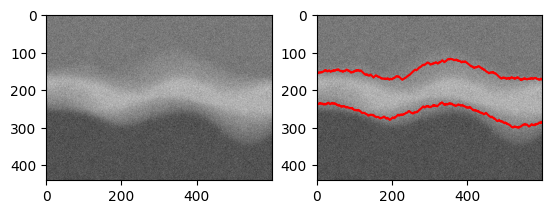

In [4]:
I = skimage.io.imread('data/peaks_image.png').astype(np.int32)

fig, ax = plt.subplots(1,2)
ax[0].imshow(I, cmap='gray')


layers = [slgbuilder.GraphObject(0*I), slgbuilder.GraphObject(0*I)]         # no on-surface cost therefore 0
helper = slgbuilder.MaxflowBuilder()                                        # Creates a helper for creating and solves a maxflow graph using the Boykov-Kolmogorov (BK) maxflow implementation. int (int32), short (int16), float (float32) or double (float64) edge capacities/energies are supported
helper.add_objects(layers)                                                  # Add object to graph 

# Adding regional costs, the region in the middle is bright compared to two darker regions.
helper.add_layered_region_cost(layers[0], I, 255-I)                         # (graph_object, outer_region_cost, inner_region_cost)
helper.add_layered_region_cost(layers[1], 255-I, I)                         # (graph_object, outer_region_cost, inner_region_cost)

# Adding geometric constrains
helper.add_layered_boundary_cost()                                          # Add layered boundary cost. This function assumes an N-D regular grid.
helper.add_layered_smoothness(delta=1, wrap=False)                          # Add hard smoothness constraint to layered object. This function assumes an N-D regular grid.
helper.add_layered_containment(layers[0], layers[1], min_margin=1)          # Add layered containment

# Cut
helper.solve()
segmentations = [helper.what_segments(l).astype(np.int32) for l in layers]
segmentation_lines = [s.shape[0] - np.argmax(s[::-1,:], axis=0) - 1 for s in segmentations]

# Visualization
ax[1].imshow(I, cmap='gray')
for line in segmentation_lines:
    ax[1].plot(line, 'r')

plt.show()

**3. Inspect the image ```rammed-earth-layers-limestone.jpg```**


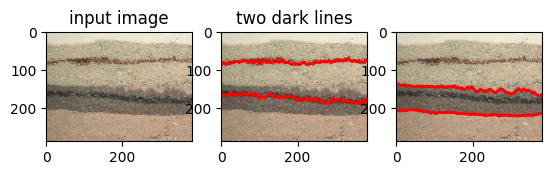

In [ ]:
I = skimage.io.imread('data/rammed-earth-layers-limestone.jpg').astype(np.int32)

fig, ax = plt.subplots(1,3)
ax[0].imshow(I, cmap='gray')
ax[0].set_title('input image')



# detect the two lines
layers = [slgbuilder.GraphObject(I), slgbuilder.GraphObject(I) ]
delta = 3

helper = slgbuilder.MaxflowBuilder()
helper.add_objects(layers)
helper.add_layered_boundary_cost()
helper.add_layered_smoothness(delta=delta, wrap=False)  
helper.add_layered_containment(layers[0], layers[1], min_margin=30)

helper.solve()
segmentations = [helper.what_segments(l).astype(np.int32) for l in layers]
segmentation_lines = [s.shape[0] - np.argmax(s[::-1,:], axis=0) - 1 for s in segmentations]

ax[1].imshow(I, cmap='gray')
for line in segmentation_lines:
    ax[1].plot(line, 'r')
ax[1].set_title('two dark lines')



# the dark region
layers = [slgbuilder.GraphObject(0*I), slgbuilder.GraphObject(0*I)]         # no on-surface cost therefore 0
helper = slgbuilder.MaxflowBuilder()                                        # Creates a helper for creating and solves a maxflow graph using the Boykov-Kolmogorov (BK) maxflow implementation. int (int32), short (int16), float (float32) or double (float64) edge capacities/energies are supported
helper.add_objects(layers)                                                  # Add object to graph 

# Adding regional costs, the region in the middle is bright compared to two darker regions.
###################################################################################################################################
# I need to change the order below so the layers[1], I, 255-I instead of layers[0], I, 255-I because we want to find a dark region
###################################################################################################################################

helper.add_layered_region_cost(layers[0], 255-I, I)                         # (graph_object, outer_region_cost, inner_region_cost)
helper.add_layered_region_cost(layers[1], I, 255-I)                         # (graph_object, outer_region_cost, inner_region_cost)

# Adding geometric constrains
helper.add_layered_boundary_cost()                                          # Add layered boundary cost. This function assumes an N-D regular grid.
helper.add_layered_smoothness(delta=1, wrap=False)                          # Add hard smoothness constraint to layered object. This function assumes an N-D regular grid.
helper.add_layered_containment(layers[0], layers[1], min_margin=1)          # Add layered containment

# Cut
helper.solve()
segmentations = [helper.what_segments(l).astype(np.int32) for l in layers]
segmentation_lines = [s.shape[0] - np.argmax(s[::-1,:], axis=0) - 1 for s in segmentations]

# Visualization
ax[2].imshow(I, cmap='gray')
for line in segmentation_lines:
    ax[2].plot(line, 'r')
plt.show()

## 7.5 Exercise: Quantifying dental tomograms

In this exercise, you will use layered surface detection to solve a concrete image analysis problem. The problem may be solved using different approaches, and you are encouraged to find your own solution. You can therefore interpret tasks below as hints, and you don’t need to solve all the tasks.

We will address the problem of quantifying dental tomograms. The success of the dental implants depends on osseointegration, the formation of a direct interface between an implant and bone. An experiment was conducted to experiment how different conditions and treatments affect ossointegration. To assess the outcome of the experiment, we
want to measure the interface between an implant and the bone. For example, consider the two slices in Figure 7.4.

**1. Inspect the data.**

**2. Use unwapping to handle tubular (circular) data.**

**3. Detect the layer corresponding to the surface of the dental implant.**

- You may treat the slices individually or as a 3D volume.


**4. For one measure of osseointegration consider a curve displaced 20 pixels from the surface of the implant**
    
- Express the measure of osseointegration as the percentage of this curve which is passing trough bone. You may use thresholding to divide bone from air (threshold is around 110). You should get the result similar to Figure 7.5.

**5. Optional challenge. For another measure of osseointegration detect a surface (curve) defining the transition from bone to air in vicinity of the implant surface**.

- Quantify the distance between the bone and the implant, for example as the mean distance. You may also produce a histogram of distances.

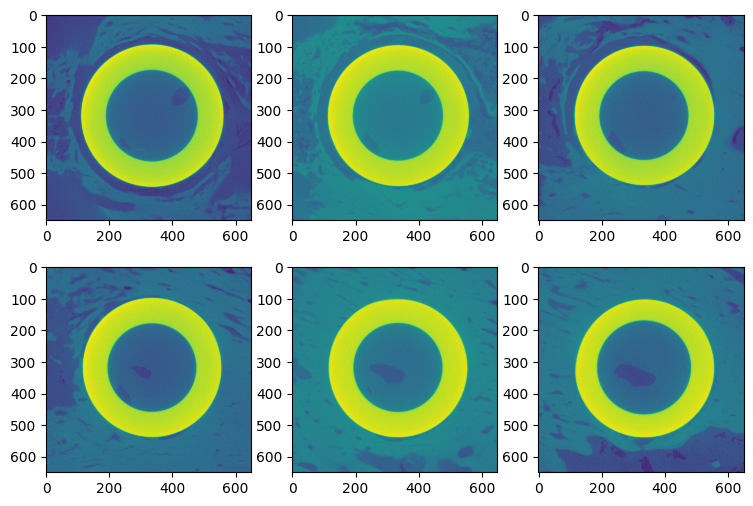

In [6]:
images = get_gray_image_float('data/dental_slices.tif')

fig, ax = plt.subplots(2, 3, figsize=(9,6))
ax = ax.flatten()

for i in range(6):
    ax[i].imshow(images[i])

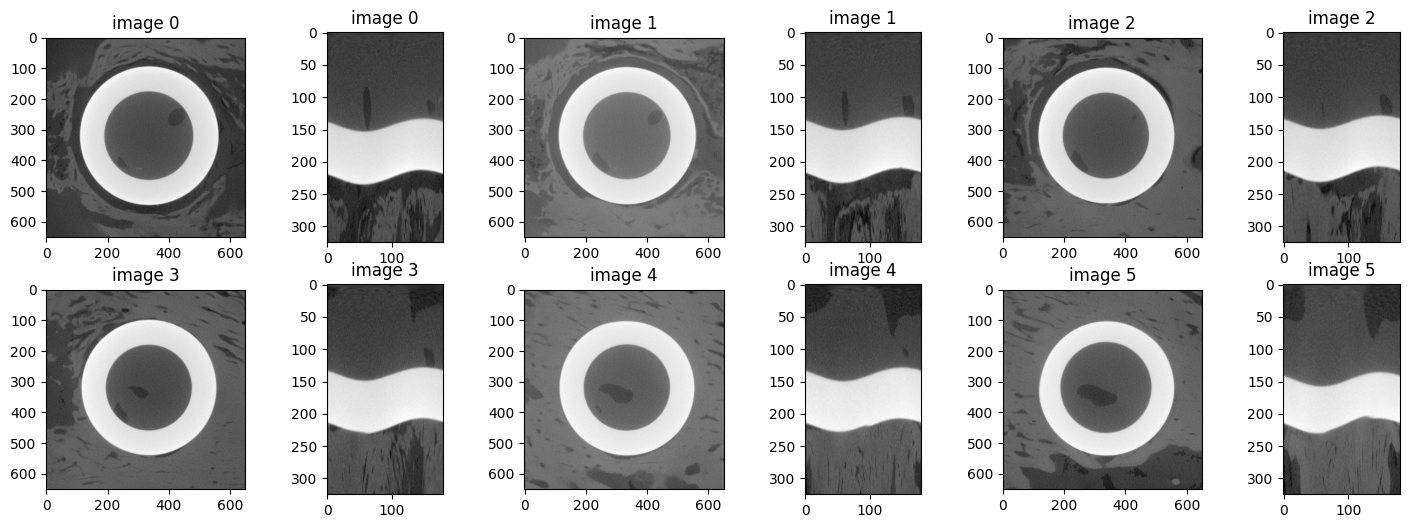

In [7]:
a = 180 # number of angles for unfolding
angles = np.arange(a)*2*np.pi/a # angular coordinate
unwrap_list = []


fig, ax = plt.subplots(2,6, figsize=(18, 6))
ax = ax.flatten()
for i, I in enumerate(images):
    center = (np.array(I.shape)-1)/2
    r = int(min(I.shape)/2)
    radii = np.arange(r) + 1 #radial coordinate for unwrapping

    X = center[0] + np.outer(radii,np.cos(angles))
    Y = center[1] + np.outer(radii,np.sin(angles))

    F = scipy.interpolate.interp2d(np.arange(I.shape[0]), np.arange(I.shape[1]), I)
    U = np.array([F(p[0],p[1]) for p in np.c_[Y.ravel(),X.ravel()]])
    U = U.reshape((r,a))
    unwrap_list.append(U) #.astype(np.int32)

    ax[2*i].imshow(I, cmap='gray')
    ax[2*i].set_title(f'image {i}')
    ax[2*i+1].imshow(U, cmap='gray')
    ax[2*i+1].set_title(f'image {i}')

unwrap = np.stack(unwrap_list)


Find the implants surface in the transformed image

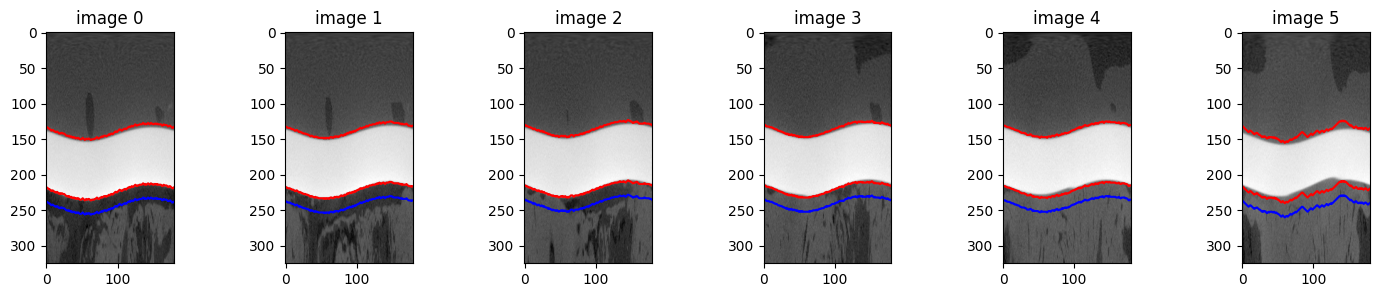

In [8]:
fig, ax = plt.subplots(1, 6, figsize=(18, 3))
measure_location_list = []


for i, I in enumerate(unwrap):    
    # the dark region
    layers = [slgbuilder.GraphObject(0*I), slgbuilder.GraphObject(0*I)]         # no on-surface cost therefore 0
    helper = slgbuilder.MaxflowBuilder()                                        # Creates a helper for creating and solves a maxflow graph using the Boykov-Kolmogorov (BK) maxflow implementation. int (int32), short (int16), float (float32) or double (float64) edge capacities/energies are supported
    helper.add_objects(layers)                                                  # Add object to graph 

    # Adding regional costs, the region in the middle is bright compared to two darker regions.
    helper.add_layered_region_cost(layers[0], I, 255-I)                         # (graph_object, outer_region_cost, inner_region_cost)
    helper.add_layered_region_cost(layers[1], 255-I, I)                         # (graph_object, outer_region_cost, inner_region_cost)

    # Adding geometric constrains
    helper.add_layered_boundary_cost()                                          # Add layered boundary cost. This function assumes an N-D regular grid.
    helper.add_layered_smoothness(delta=1, wrap=False)                          # Add hard smoothness constraint to layered object. This function assumes an N-D regular grid.
    helper.add_layered_containment(layers[0], layers[1], min_margin=85)          # Add layered containment

    # Cut
    helper.solve()
    segmentations = [helper.what_segments(l).astype(np.int32) for l in layers]
    segmentation_lines = [s.shape[0] - np.argmax(s[::-1,:], axis=0) - 1 for s in segmentations]
    measure_location = segmentation_lines[0] + 20
    measure_location_list.append(measure_location)                          # this is a list of an list, the first element is the lowest line


    # Visualization
    ax[i].imshow(I, cmap='gray')
    for line in segmentation_lines:
        ax[i].plot(line, 'r')
        ax[i].set_title(f'image {i}')
    ax[i].plot(measure_location, 'b')
    
plt.show()


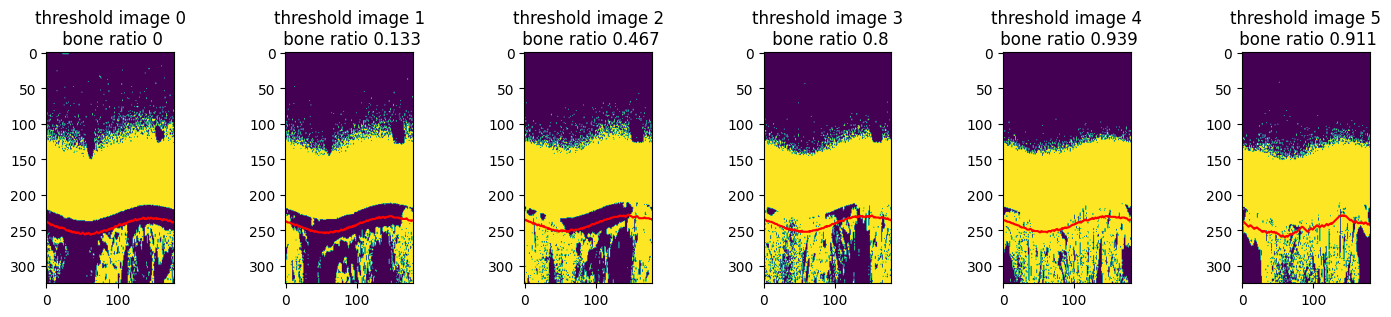

In [9]:
fig, ax = plt.subplots(1, 6, figsize=(18, 3))
unwrap_threshold = unwrap > 115/255

for i, I in enumerate(unwrap_threshold):
    idx = (np.arange(len(measure_location_list[1])), measure_location_list[1])
    bone_ratio = np.mean(unwrap_threshold[i, measure_location_list[i], np.arange(len(measure_location_list[i]))])
    
    ax[i].imshow(I)
    ax[i].set_title(f'threshold image {i}\n bone ratio {bone_ratio:.3g}') 
    ax[i].plot(np.arange(len(measure_location_list[i])), measure_location_list[i], 'r') 

## 7.6 Exercise: Quantifying abdominal fat

This is another quantitative image analysis problem which may be solved using layered surfaces. The task is to measure the thickness of abdominal fat from the MRI (magnetic resonance imaging) scans. For example, consider the image in Figure 7.6. The MRI images share similarities with the slices from dental implants, so you can re-use some parts of the code developed for the previous exercise. However, abdominal cross-section is less circular than dental implant, so you might need to adjust the parameter δ.


**1. Inspect the data**

**2. Use unwapping to handle tubular (circular) data**

**3. Detect two layer corresponding to the outer and inner surface of the abdominal fat.**

**4. Estimate the average thickness of the abdominal fat (in pixels)**
- One way of achieving this is to compute the radial distances between the inner and the outer surface and average these distances. Alternatively, you can compute the fat area, and divide with abdominal circumference.

(650, 650)
(230, 320)


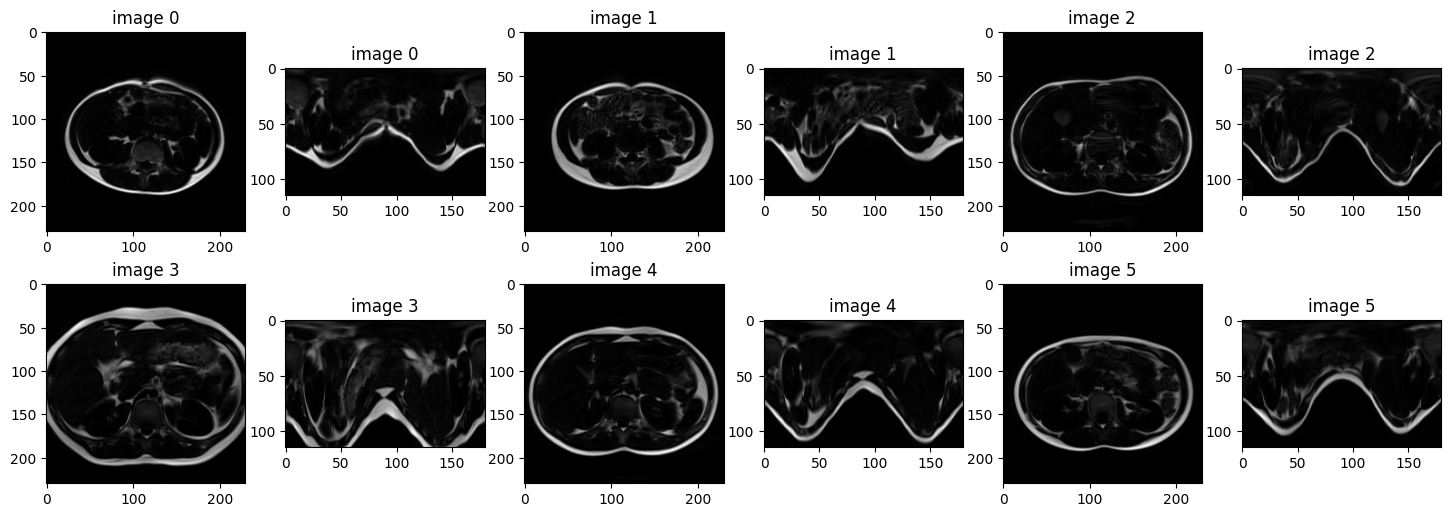

In [10]:
image_paths = ['IM_1016.png', 'IM_1041.png', 'IM_1306.png', 'IM_1334.png', 'IM_1347.png', 'IM_1429.png']

a = 180 # number of angles for unfolding
angles = np.arange(a)*2*np.pi/a # angular coordinate
unwrap_list = []

fig, ax = plt.subplots(2,6, figsize=(18, 6))
ax = ax.flatten()
images = get_gray_image_float('data/dental_slices.tif')
print(images[0].shape)

images = get_gray_image_float(PATH + 'AbFat/' + image_paths[0])
print(images.shape)

for i, image_path in enumerate(image_paths):
    I = get_gray_image_255(PATH + 'AbFat/' + image_path)

    # the code below is added to ensure that the shape of the image is equal original is 230, 320 and need it to be 230, 230
    remove_edge = np.int((I.shape[1] - I.shape[0])/2)
    I = I[:, remove_edge:-remove_edge]

    center = (np.array(I.shape)-1)/2
    r = int(min(I.shape)/2)
    radii = np.arange(r) + 1 #radial coordinate for unwrapping

    X = center[0] + np.outer(radii,np.cos(angles))
    Y = center[1] + np.outer(radii,np.sin(angles))

    F = scipy.interpolate.interp2d(np.arange(I.shape[0]), np.arange(I.shape[1]), I)
    U = np.array([F(p[0],p[1]) for p in np.c_[Y.ravel(),X.ravel()]])
    U = U.reshape((r,a))
    unwrap_list.append(U) #.astype(np.int32)

    ax[2*i].imshow(I, cmap='gray')
    ax[2*i].set_title(f'image {i}')
    ax[2*i+1].imshow(U, cmap='gray')
    ax[2*i+1].set_title(f'image {i}')


unwrap = np.stack(unwrap_list)

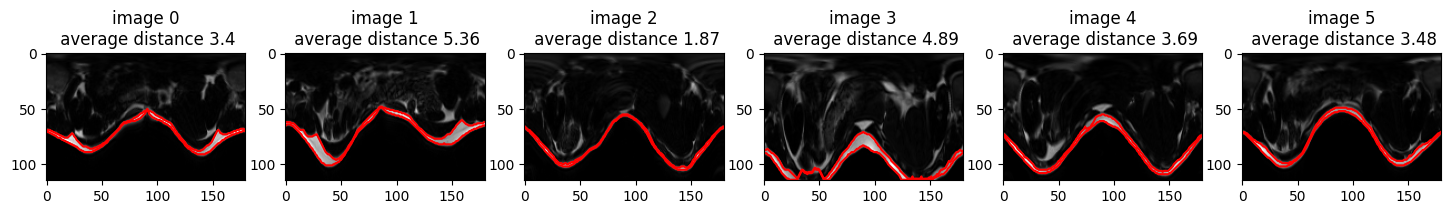

In [11]:
fig, ax = plt.subplots(1, 6, figsize=(18, 3))
measure_location_list = []


for i, I in enumerate(unwrap):    
    # the dark region
    layers = [slgbuilder.GraphObject(0*I), slgbuilder.GraphObject(0*I)]         # no on-surface cost therefore 0
    helper = slgbuilder.MaxflowBuilder()                                        # Creates a helper for creating and solves a maxflow graph using the Boykov-Kolmogorov (BK) maxflow implementation. int (int32), short (int16), float (float32) or double (float64) edge capacities/energies are supported
    helper.add_objects(layers)                                                  # Add object to graph 

    # Adding regional costs, the region in the middle is bright compared to two darker regions.
    helper.add_layered_region_cost(layers[0], I, 255-I)                         # (graph_object, outer_region_cost, inner_region_cost)
    helper.add_layered_region_cost(layers[1], 255-I, I)                         # (graph_object, outer_region_cost, inner_region_cost)

    # Adding geometric constrains
    helper.add_layered_boundary_cost()                                          # Add layered boundary cost. This function assumes an N-D regular grid.
    helper.add_layered_smoothness(delta=2, wrap=False)                          # Add hard smoothness constraint to layered object. This function assumes an N-D regular grid.
    helper.add_layered_containment(layers[0], layers[1], min_margin=1)          # Add layered containment

    # Cut
    helper.solve()
    segmentations = [helper.what_segments(l).astype(np.int32) for l in layers]
    segmentation_lines = [s.shape[0] - np.argmax(s[::-1,:], axis=0) - 1 for s in segmentations]

    # calculate the average distance between these lines
    mean_dist = np.mean(np.abs(segmentation_lines[0] - segmentation_lines[1]))
    # Visualization
    ax[i].imshow(I, cmap='gray')
    for line in segmentation_lines:
        ax[i].plot(line, 'r')
        ax[i].set_title(f'image {i}\n average distance {mean_dist:.3g}')
    
plt.show()


## QUIZ

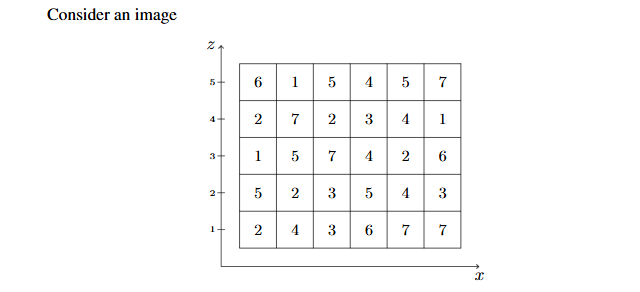

In [12]:
image = np.array([6, 1, 5, 4, 5, 7, 2, 7, 2, 3, 4, 1, 1, 5, 7, 4, 2, 6, 5, 2, 3, 5, 4, 3, 2, 4, 3, 6, 7, 7]).reshape(5,6)
print('The image is given as:\n', image)

The image is given as:
 [[6 1 5 4 5 7]
 [2 7 2 3 4 1]
 [1 5 7 4 2 6]
 [5 2 3 5 4 3]
 [2 4 3 6 7 7]]


### 1.  What is the cost of the line given by $f(x) = 2$?

In [13]:
row_2 = image[-2,:]
cost = np.sum(row_2)
print('The second row is:\n', row_2)
print(f'The cost is given by:', cost)

The second row is:
 [5 2 3 5 4 3]
The cost is given by: 22


### 2.  What is the cost of the min-cost solution constrained by $\Delta_x = 0$

This means, that I'm not allowed to change my direction in x, so I need to find the line, with the lowest cost, that is parallel to the x-axis.

The segmentation line is: [1 1 1 1 1 1]
The value path is given as: [2 7 2 3 4 1]
The sum of the value path is given as: 19


Text(0.5, 1.0, 'Optimal path for delta 0 with value 19')

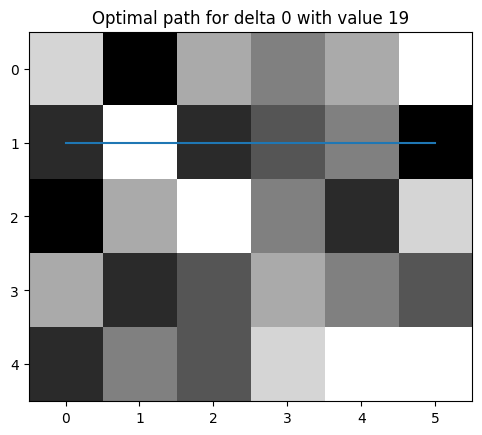

In [14]:
I = image
delta = 0

layer = slgbuilder.GraphObject(I)                           # Creates a GraphObject for storing data and data points (use surface cost)
helper = slgbuilder.MaxflowBuilder()                        # Creates a helper for creating and solves a maxflow graph using the Boykov-Kolmogorov (BK) maxflow implementation. int (int32), short (int16), float (float32) or double (float64) edge capacities/energies are supported
helper.add_object(layer)                                    # Add object to graph 
helper.add_layered_boundary_cost()                          # Add layered boundary cost. This function assumes an N-D regular grid.
helper.add_layered_smoothness(delta=delta, wrap=False)          # Add hard smoothness constraint to layered object. This function assumes an N-D regular grid.

helper.solve()
segmentation = helper.what_segments(layer)                  # return true and false
segmentation_line = segmentation.shape[0] - np.argmax(segmentation[::-1,:], axis=0) - 1

value_path = I[segmentation_line, np.arange(I.shape[1])]
value = np.sum(value_path)
# value = np.sum(I[np.arange(len(segmentation_line)), segmentation_line])

print(f'The segmentation line is: {segmentation_line}')
print(f'The value path is given as: {value_path}')
print(f'The sum of the value path is given as: {value}')

plt.imshow(I, cmap='gray')
plt.plot(np.arange(len(segmentation_line)), segmentation_line)
plt.title(f'Optimal path for delta {delta} with value {value}')


### 3.  What is the cost of the min-cost solution constrained by $\Delta_x= 3$?


The segmentation line is: [2 0 1 1 2 1]
The value path is given as: [1 1 2 3 2 1]
The sum of the value path is given as: 10


Text(0.5, 1.0, 'Optimal path for delta 3 with value 10')

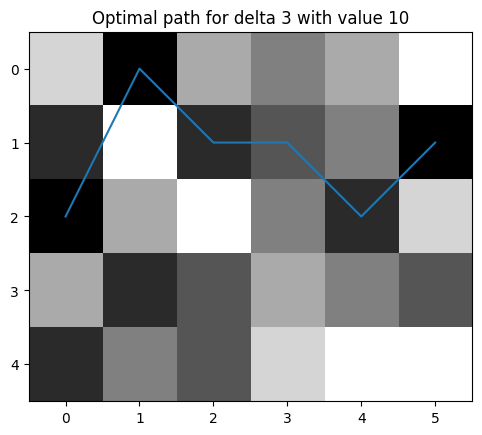

In [15]:
I = image
delta = 3

layer = slgbuilder.GraphObject(I)                           # Creates a GraphObject for storing data and data points (use surface cost)
helper = slgbuilder.MaxflowBuilder()                        # Creates a helper for creating and solves a maxflow graph using the Boykov-Kolmogorov (BK) maxflow implementation. int (int32), short (int16), float (float32) or double (float64) edge capacities/energies are supported
helper.add_object(layer)                                    # Add object to graph 
helper.add_layered_boundary_cost()                          # Add layered boundary cost. This function assumes an N-D regular grid.
helper.add_layered_smoothness(delta=delta, wrap=False)          # Add hard smoothness constraint to layered object. This function assumes an N-D regular grid.

helper.solve()
segmentation = helper.what_segments(layer)                  # return true and false
segmentation_line = segmentation.shape[0] - np.argmax(segmentation[::-1,:], axis=0) - 1

value_path = I[segmentation_line, np.arange(I.shape[1])]
value = np.sum(value_path)
# value = np.sum(I[np.arange(len(segmentation_line)), segmentation_line])

print(f'The segmentation line is: {segmentation_line}')
print(f'The value path is given as: {value_path}')
print(f'The sum of the value path is given as: {value}')

plt.imshow(I, cmap='gray')
plt.plot(np.arange(len(segmentation_line)), segmentation_line)
plt.title(f'Optimal path for delta {delta} with value {value}')
